<a href="https://colab.research.google.com/github/Ioxxox/Apple-Leaf-Classifier/blob/main/Apple_Leaf_Disease_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the PlantVillage dataset from Kaggle
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('PlantVillage Dataset')

In [3]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.stats import mode, pearsonr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# dataset folder path
data_folder = "PlantVillage Dataset/plantvillage dataset/grayscale"

# Categories (folders for Apple dataset)
categories = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']

# lists to store images and labels
images = []
labels = []

# Iterate through each category folder
for category in categories:
    folder_path = os.path.join(data_folder, category)

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    print(f"Processing folder: {category}")

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load the image
            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img = img.resize((64, 64))

            images.append(np.array(img).flatten())
            labels.append(category)

# Converting lists to numpy arrays
data_matrix = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(data_matrix)} images.")
print(f"Labels: {np.unique(labels)}")



Processing folder: Apple___Apple_scab
Processing folder: Apple___Black_rot
Processing folder: Apple___healthy
Loaded 2896 images.
Labels: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___healthy']


In [5]:
# Standardizing the data matrix
scaler = StandardScaler()
data_matrix_scaled = scaler.fit_transform(data_matrix)

Number of components to preserve 90% variance: 121


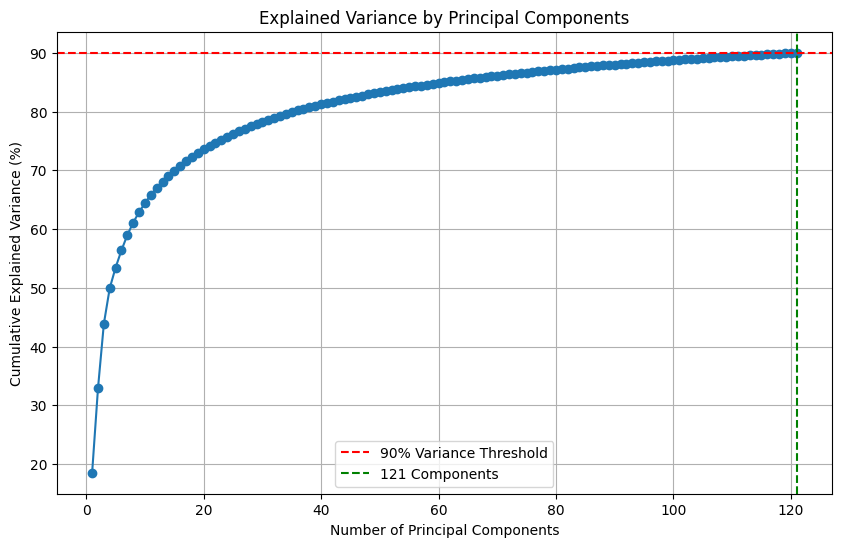

In [6]:
pca = PCA(0.90)
pca.fit(data_matrix_scaled)
n_components_90_variance = pca.n_components_
print(f"Number of components to preserve 90% variance: {n_components_90_variance}")

# Transforming data to reduced dimension
data_matrix_reduced = pca.transform(data_matrix_scaled)

# cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label="90% Variance Threshold")
plt.axvline(x=n_components_90_variance, color='g', linestyle='--', label=f"{n_components_90_variance} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid(True)
plt.show()

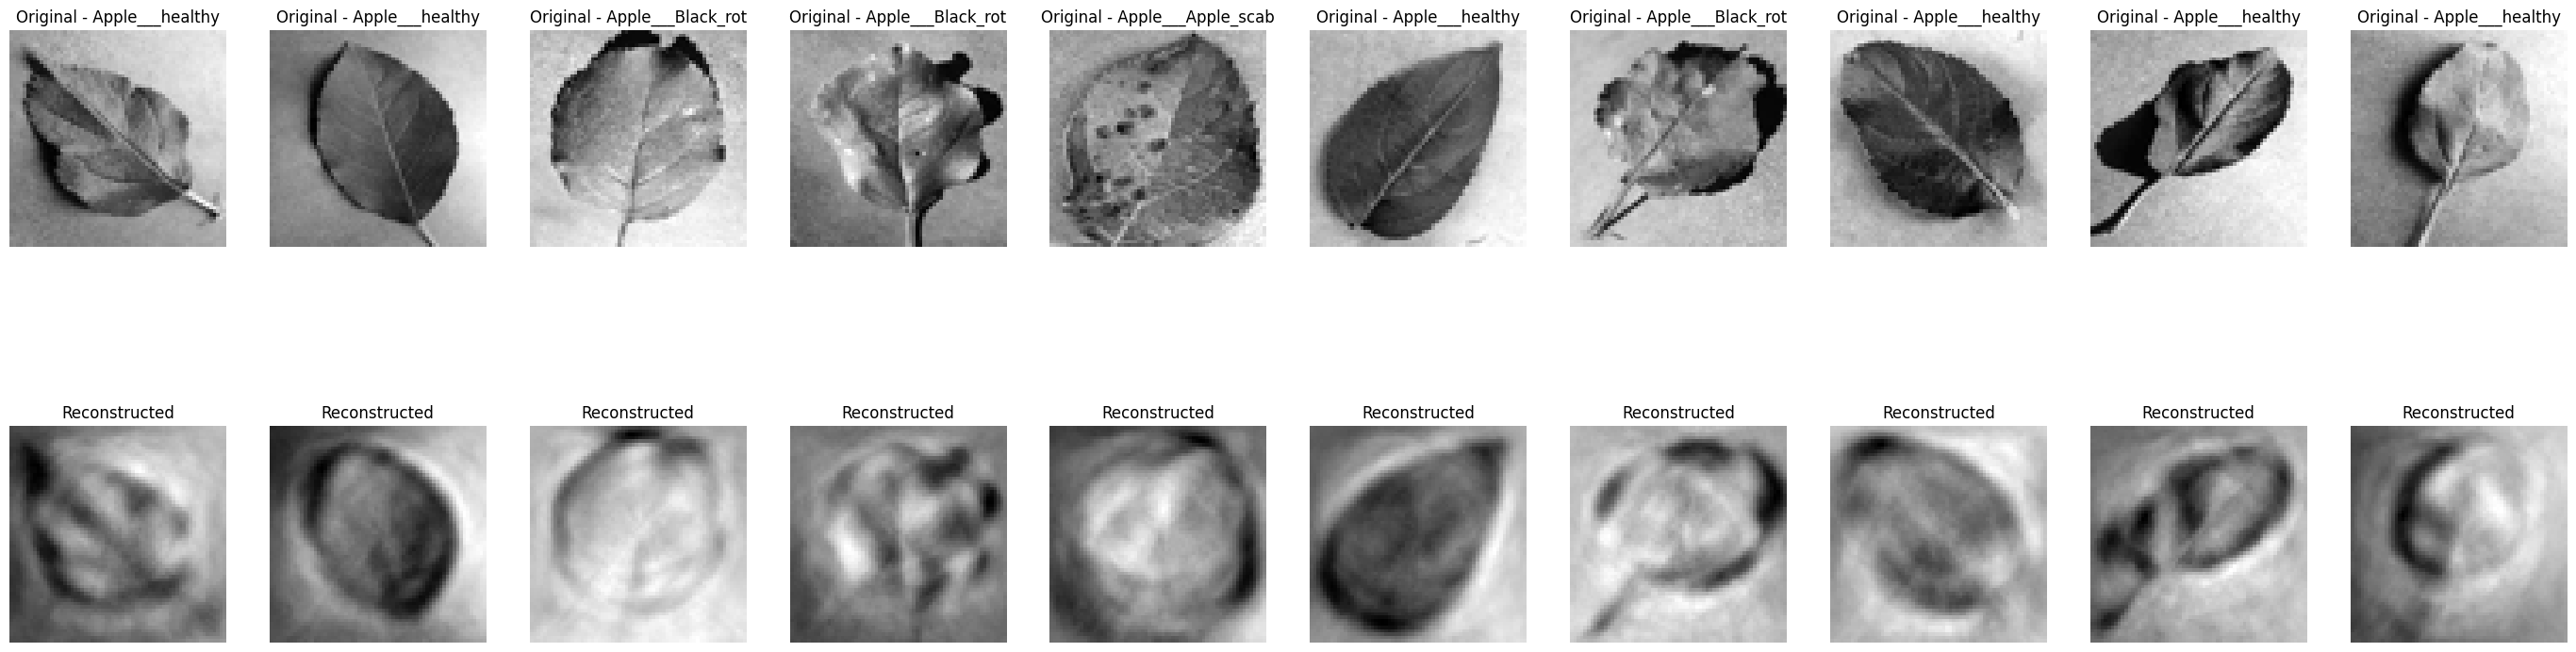

In [7]:
data_matrix_reconstructed = pca.inverse_transform(data_matrix_reduced)

# random images
num_images = 10
indices = np.random.choice(len(data_matrix), num_images, replace=False)
selected_images_original = data_matrix[indices]
selected_images_reconstructed = data_matrix_reconstructed[indices]

# original and reconstructed images
plt.figure(figsize=(35, 10))
for i in range(num_images):

    # Original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected_images_original[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title(f"Original - {labels[indices[i]]}")

    # Reconstructed
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(selected_images_reconstructed[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title("Reconstructed")

plt.show()

Variance explained by the first two components: 32.92%


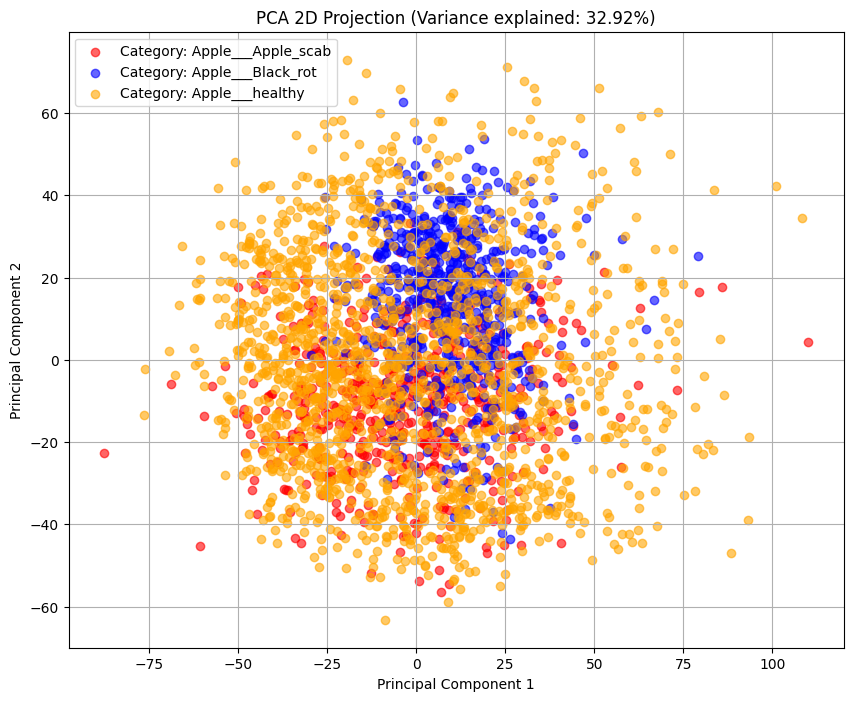

In [8]:
# PCA with 2 components
pca_2d = PCA(n_components=2)
data_matrix_2D_pca = pca_2d.fit_transform(data_matrix_scaled)
explained_variance_2d = np.sum(pca_2d.explained_variance_ratio_) * 100
print(f"Variance explained by the first two components: {explained_variance_2d:.2f}%")

# category labels and colors
categories = ['Apple___Apple_scab', 'Apple___Black_rot','Apple___healthy']
colors = {
    'Apple___Apple_scab': 'red',
    'Apple___Black_rot': 'blue',
    'Apple___healthy': 'orange'
}

# Scatter plot of the 2D PCA results
plt.figure(figsize=(10, 8))
for category in categories:
    indices = [i for i, label in enumerate(labels) if label == category]
    plt.scatter(
        data_matrix_2D_pca[indices, 0],
        data_matrix_2D_pca[indices, 1],
        label=f"Category: {category}",
        color=colors[category],
        alpha=0.6
    )

plt.title(f"PCA 2D Projection (Variance explained: {explained_variance_2d:.2f}%)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [9]:

# Helper function to plot with image overlays
def plot_with_images(X_2D, labels, images, title, min_distance=0.1, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X_2D)
    label_color_map = {'Apple___Apple_scab': 'red', 'Apple___Black_rot': 'blue', 'Apple___healthy': 'orange'}
    colors = [label_color_map[label] for label in labels]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=colors, alpha=0.5, edgecolor='k')

    max_images = 50
    indices = np.random.choice(len(X_normalized), size=min(max_images, len(X_normalized)), replace=False)

    for index in indices:
        img = images[index].reshape(64, 64)
        imagebox = AnnotationBbox(OffsetImage(img, cmap="gray", zoom=0.5), X_normalized[index], frameon=False)
        ax.add_artist(imagebox)

    plt.title(title)
    plt.axis("off")
    plt.show()

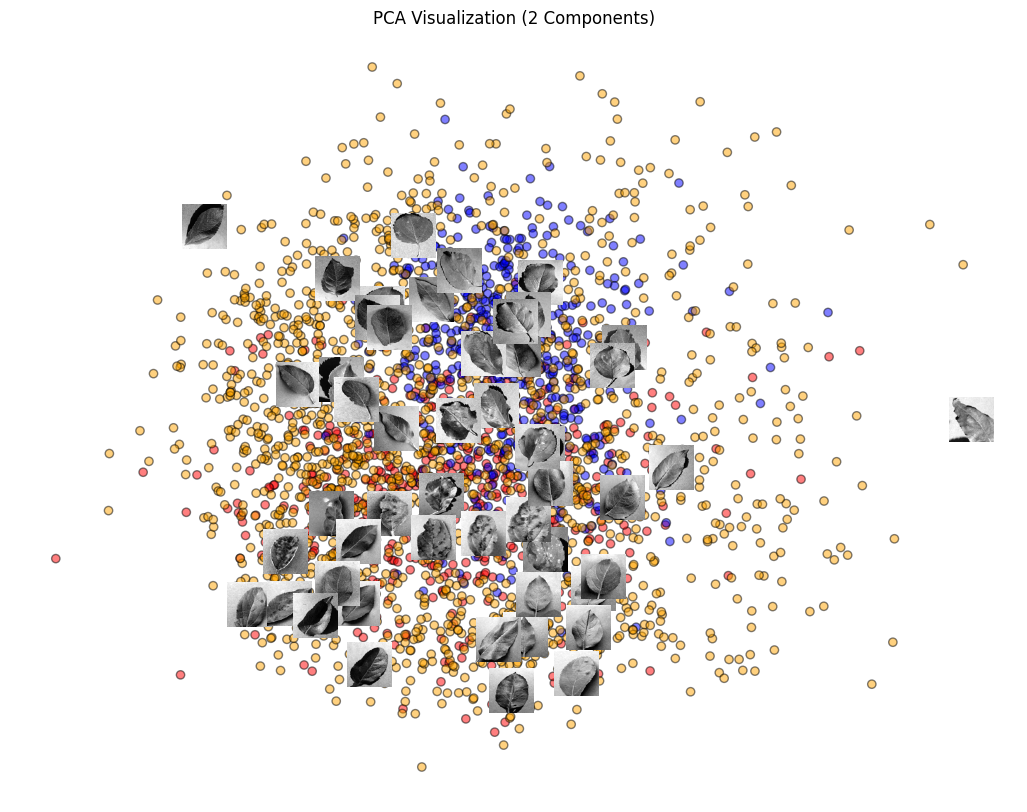

In [10]:
# PCA 2D scatter with image overlays
plot_with_images(data_matrix_2D_pca, labels, data_matrix, "PCA Visualization (2 Components)")

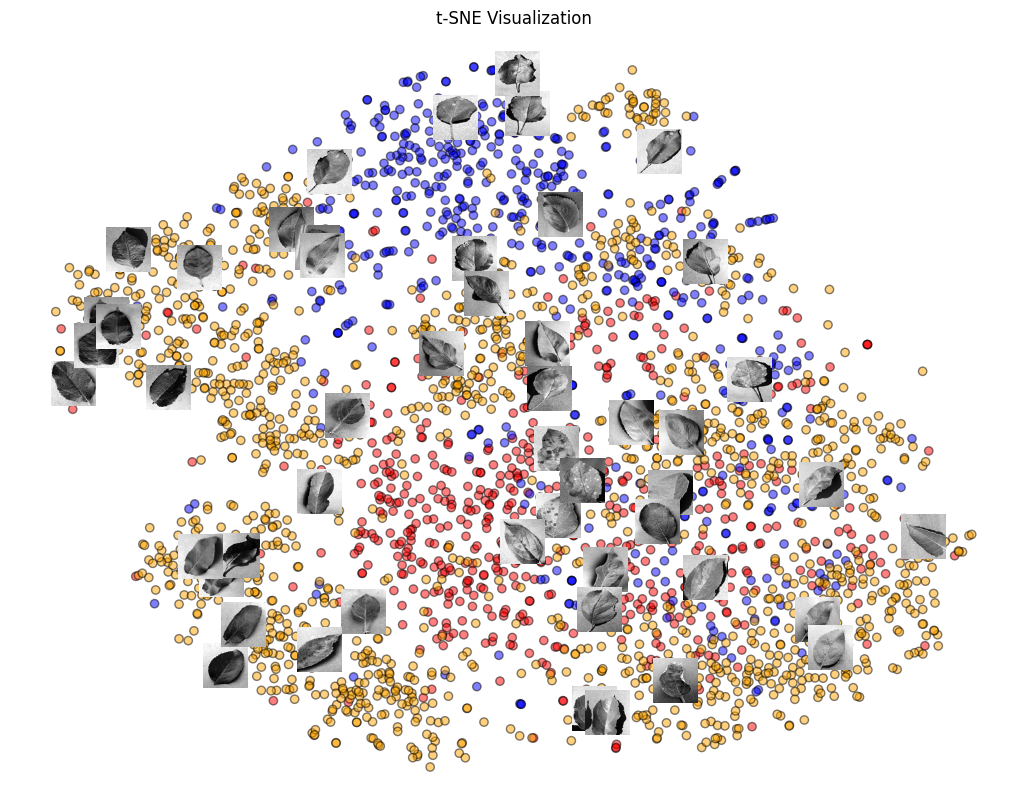

In [11]:
# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_matrix_2D_tsne = tsne.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_tsne, labels, data_matrix, "t-SNE Visualization")

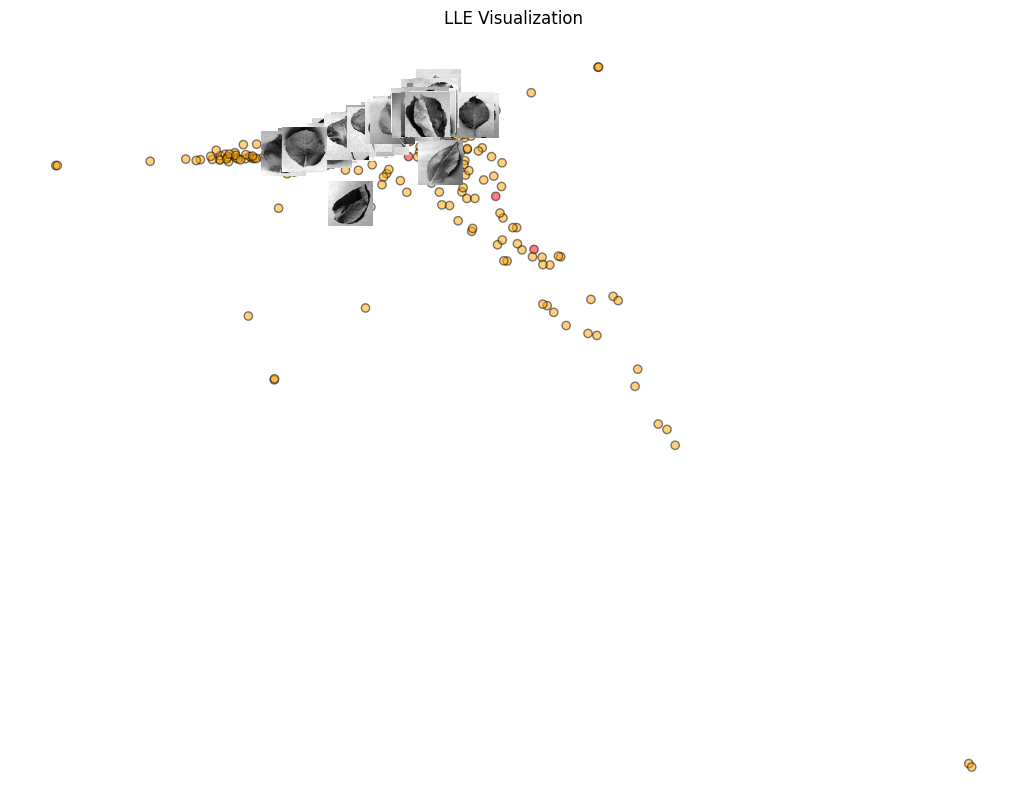

In [12]:
# LLE 2D
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
data_matrix_2D_lle = lle.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_lle, labels, data_matrix, "LLE Visualization")

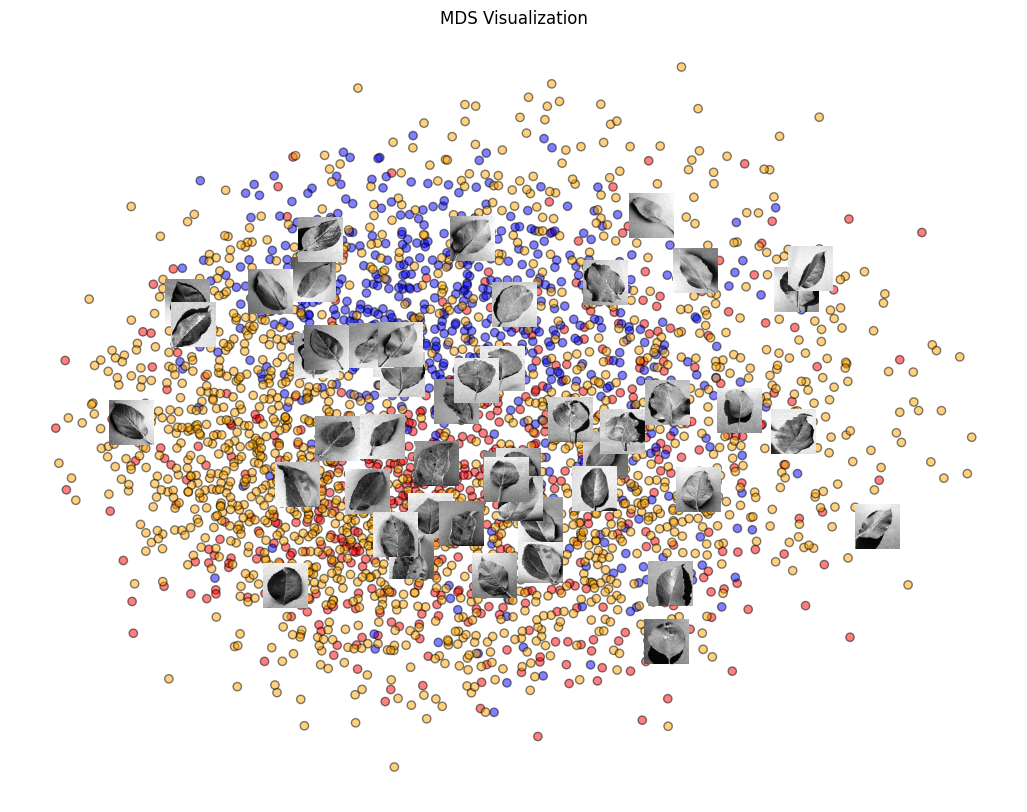

In [13]:
# MDS 2D
mds = MDS(n_components=2, random_state=42)
data_matrix_2D_mds = mds.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_mds, labels, data_matrix, "MDS Visualization")

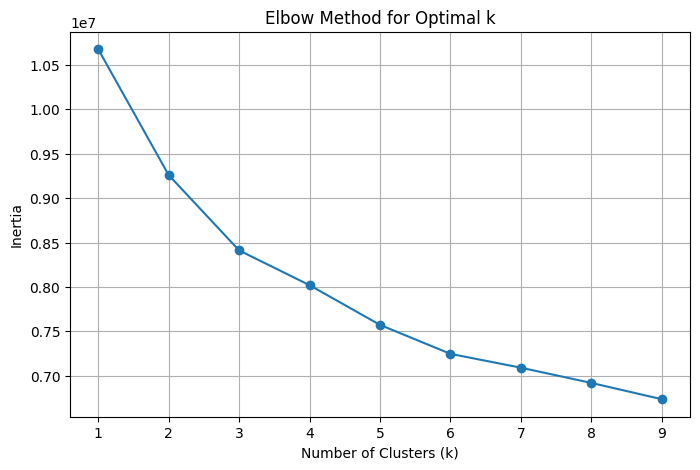

In [14]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_matrix_reduced)
    inertia.append(kmeans.inertia_)

# Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [15]:
# K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(data_matrix_reduced)

label_mapping = {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___healthy':2}
true_labels = np.array([label_mapping[label] for label in labels])

# Mapping each cluster label to true label using majority voting
mapped_labels_kmeans = np.zeros_like(cluster_labels_kmeans)
for i in range(3):
    mask = (cluster_labels_kmeans == i)
    mapped_labels_kmeans[mask] = mode(true_labels[mask])[0]

# accuracy
accuracy_kmeans = accuracy_score(true_labels, mapped_labels_kmeans)
print(f"K-Means Clustering Accuracy with k=3: {accuracy_kmeans * 100:.2f}%")

K-Means Clustering Accuracy with k=3: 58.01%


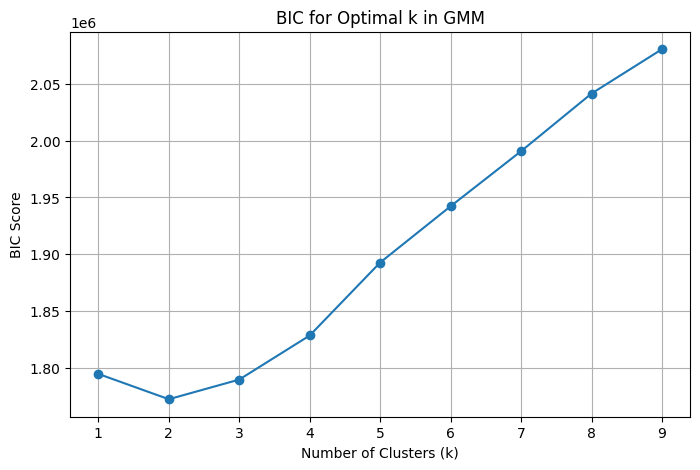

In [16]:
bic_scores = []
K_range = range(1, 10)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)
    bic_scores.append(gmm.bic(data_matrix_reduced))

# BIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("BIC for Optimal k in GMM")
plt.grid(True)
plt.show()

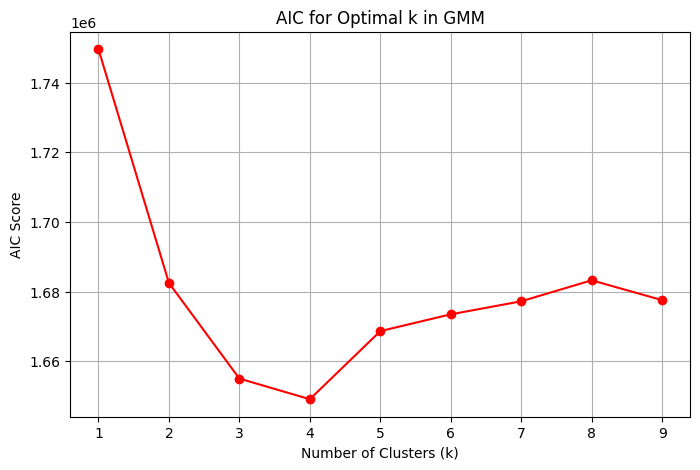

In [17]:
aic_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)
    aic_scores.append(gmm.aic(data_matrix_reduced))

# AIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, aic_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("AIC Score")
plt.title("AIC for Optimal k in GMM")
plt.grid(True)
plt.show()

In [18]:
# Fit GMM with k=3
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(data_matrix_reduced)

# Mapping GMM cluster labels to true labels using majority voting
mapped_labels_gmm = np.zeros_like(gmm_labels)
for i in range(3):
    mask = (gmm_labels == i)
    mapped_labels_gmm[mask] = mode(true_labels[mask])[0]

# accuracy
accuracy_gmm = accuracy_score(true_labels, mapped_labels_gmm)
print(f"GMM Clustering Accuracy with k=3: {accuracy_gmm * 100:.2f}%")

GMM Clustering Accuracy with k=3: 56.80%


Shape of new_samples_original: (20, 4096)


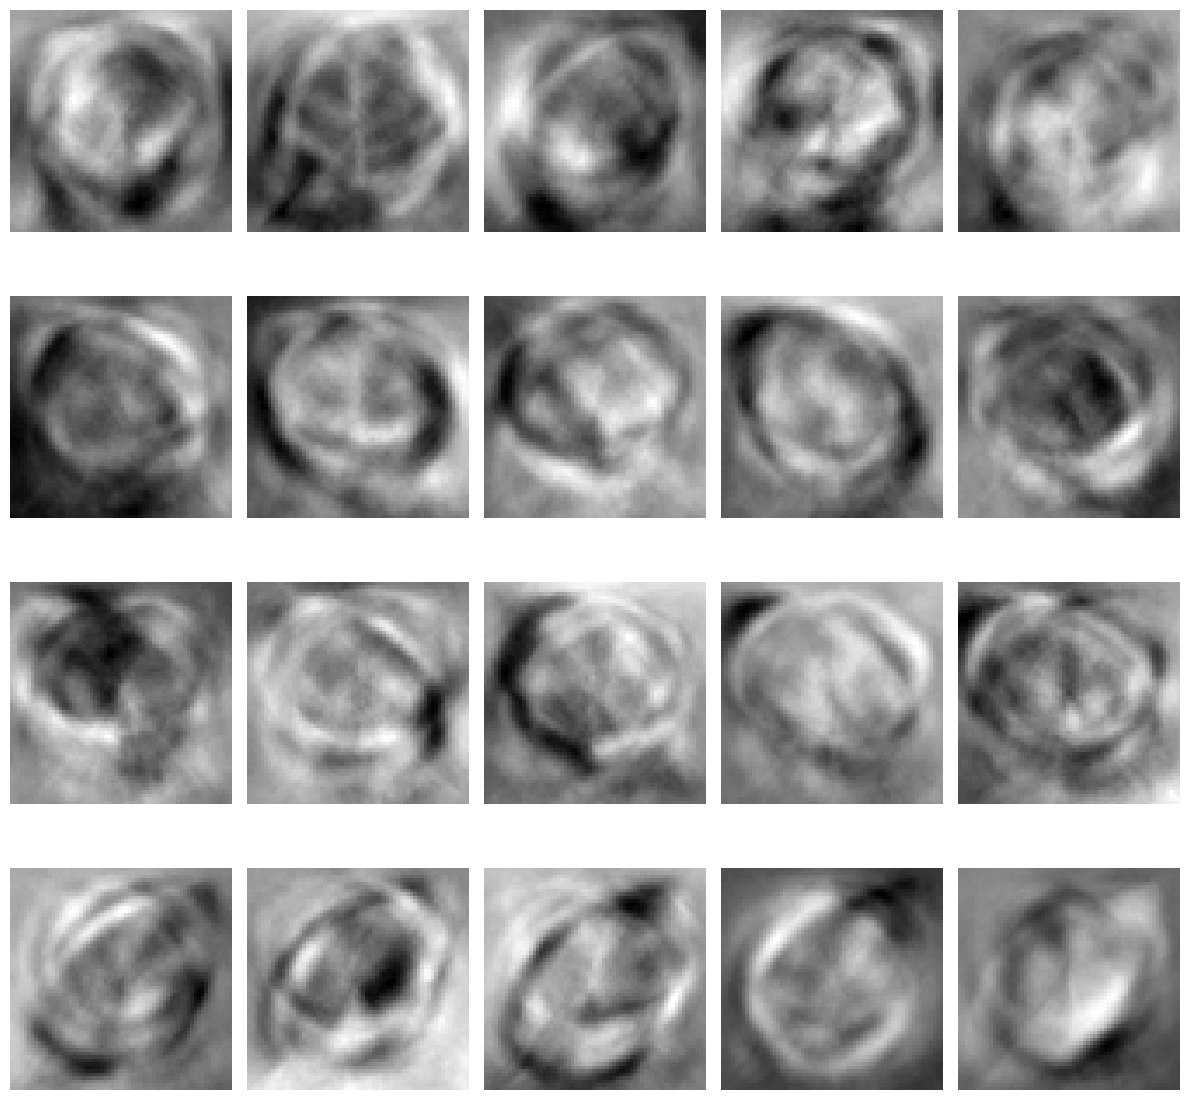

In [19]:
# 20 new samples using the GMM model
num_samples = 20
new_samples_reduced, _ = gmm.sample(num_samples)

# Inverse transform the reduced samples back to the original image space
new_samples_original = pca.inverse_transform(new_samples_reduced)

print(f"Shape of new_samples_original: {new_samples_original.shape}")

# Visualizing the 20 new "rocks"
fig, axes = plt.subplots(4, 5, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_samples):
    axes[i].imshow(new_samples_original[i].reshape(64, 64), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Encoding labels and splitting data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

train_images, val_images, train_labels, val_labels = train_test_split(data_matrix_scaled, one_hot_labels, test_size=0.2, random_state=42, stratify = encoded_labels)

# Reshaping the data to match the input shape expected by the model
train_images = train_images.reshape(-1, 64, 64, 1)
val_images = val_images.reshape(-1, 64, 64, 1)

print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

Training images: (2316, 64, 64, 1)
Validation images: (580, 64, 64, 1)
Number of classes: 3


In [21]:
# input shape and number of classes
input_shape = (64, 64, 1)
num_classes = len(label_encoder.classes_)

inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

# Early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = time.time()
history = model.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time with Early Stopping: {training_time:.2f} seconds")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,427 (2.64 MB)

 Trainable params: 691,427 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.5914 - loss: 0.8767 - val_accuracy: 0.7966 - val_loss: 0.4928
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.7893 - loss: 0.5162 - val_accuracy: 0.8448 - val_loss: 0.3836
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.8566 - loss: 0.3621 - val_accuracy: 0.8466 - val_loss: 0.3862
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.8913 - loss: 0.2916 - val_accuracy: 0.8948 - val_loss: 0.3004
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.9215 - loss: 0.2110 - val_accuracy: 0.8966 - val_loss: 0.3086
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.9484 - loss: 0.1395 - val_accuracy: 0.9034 - val_loss: 0.2632
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.9522 - loss: 0.1346 - val_accuracy: 0.9086 - val_loss: 0.3016
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.9746 - loss: 0.0733 - val_accu

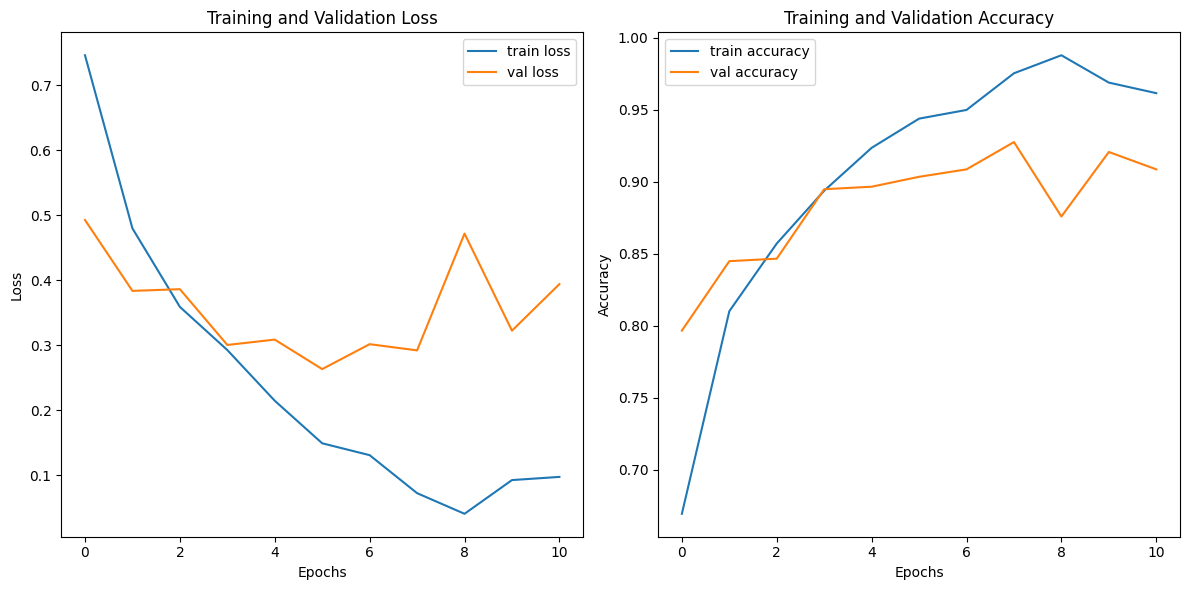

In [22]:
# training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [23]:
# total number of parameters
total_params = model.count_params()

# bias parameters
bias_params = sum(np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name)

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")

Total parameters: 691427
Bias parameters: 427
